In [1]:
# prompt: connect to google drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install transformers
!pip install imblearn

In [3]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
# Import AdamW from torch.optim instead of transformers
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [5]:
# prompt: read csv file from google drive to dataframe

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Research on BD NYU /development/multi class depression dataset/dataset.csv')
print(df.head())


                                              Tweets      Labels
0  I been going thru depression  I didnt even rea...  postpartum
1  @keshab_mahanta hello Health minister sir,I m ...  postpartum
2  FYI in case anyone is concerned - I am NOT act...  postpartum
3  @victorr_ugo Thankful I am able to hold my bab...  postpartum
4  I think I might be suffering from  depression ...  postpartum


#### 1.0 EDA

In [6]:
# Basic stats
print(f"Total tweets: {len(df)}")
print(f"Unique labels: {df['Labels'].unique()}")

Total tweets: 14996
Unique labels: ['postpartum' 'major depressive' 'psychotic' 'no' nan 'bipolar' 'atypical']


In [7]:
df['Labels'].value_counts()

,count
Labels,
postpartum,3747
major depressive,2517
bipolar,2443
psychotic,2312
no,1985
atypical,1980


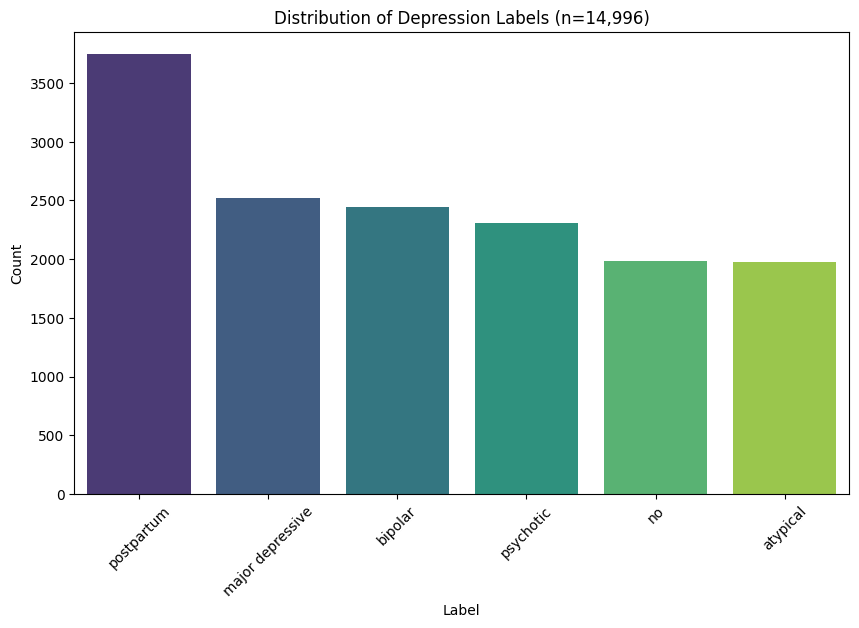

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count labels (handling NaN if needed)
label_counts = df['Labels'].value_counts(dropna=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Distribution of Depression Labels (n=14,996)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [9]:
from wordcloud import WordCloud

# Group by label
for label in df['Labels'].unique():
    if pd.isna(label):
        continue  # Skip NaN
    text = " ".join(df[df['Labels'] == label]['Tweets'].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud: {label}")
    plt.axis('off')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

Text Length Analysis

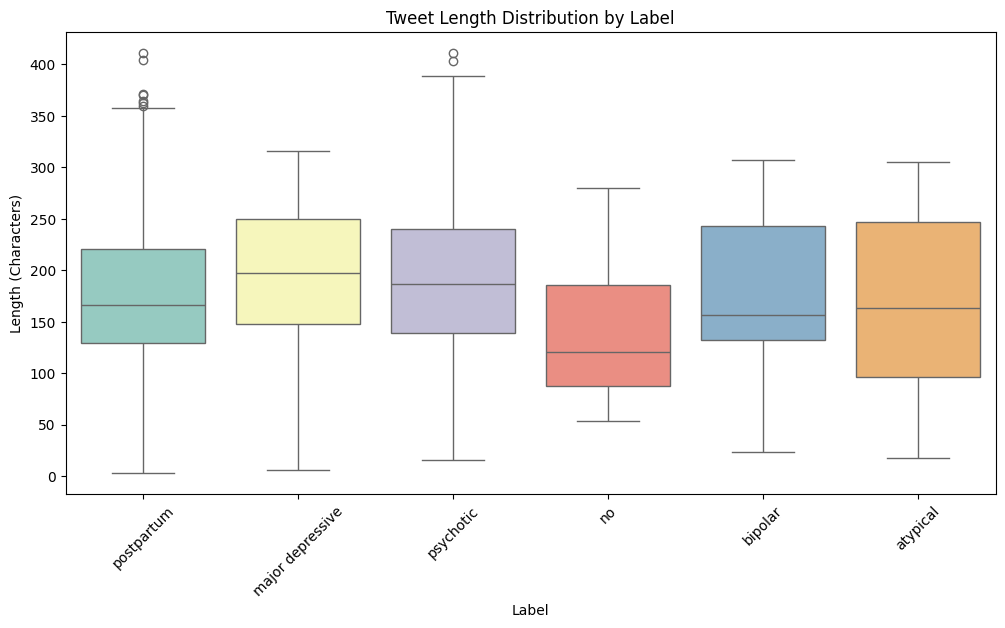

In [10]:
# Calculate tweet length
df['tweet_length'] = df['Tweets'].apply(lambda x: len(str(x)))

# Plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='Labels', y='tweet_length', data=df, palette="Set3")
plt.title("Tweet Length Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Length (Characters)")
plt.xticks(rotation=45)
plt.show()

Sentiment Polarity

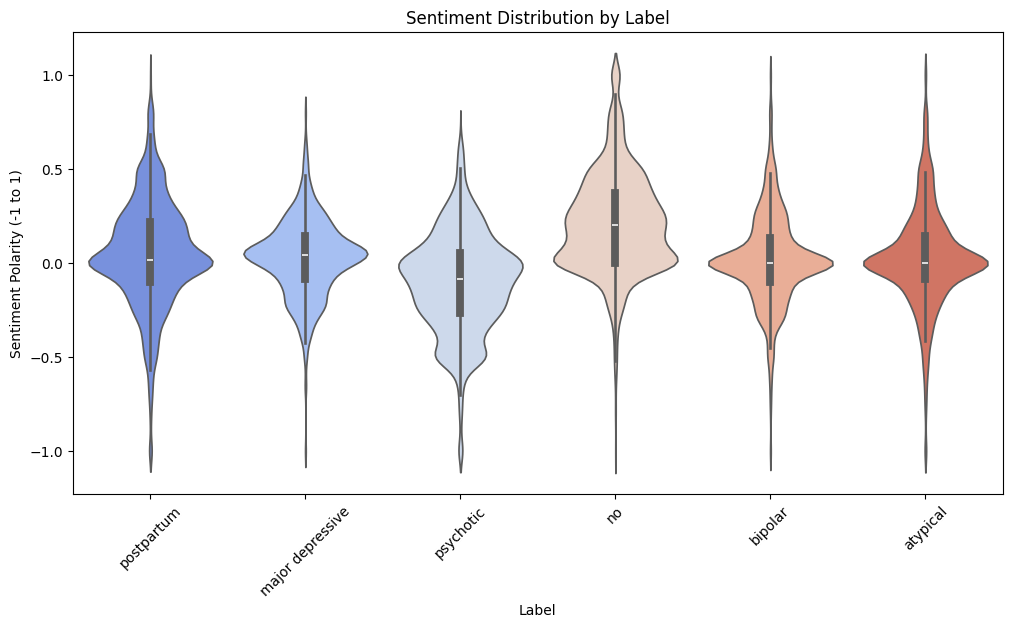

In [11]:
from textblob import TextBlob

# Calculate sentiment
df['sentiment'] = df['Tweets'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Plot
plt.figure(figsize=(12, 6))
sns.violinplot(x='Labels', y='sentiment', data=df, palette="coolwarm")
plt.title("Sentiment Distribution by Label")
plt.xlabel("Label")
plt.ylabel("Sentiment Polarity (-1 to 1)")
plt.xticks(rotation=45)
plt.show()

Top N-Grams by Label

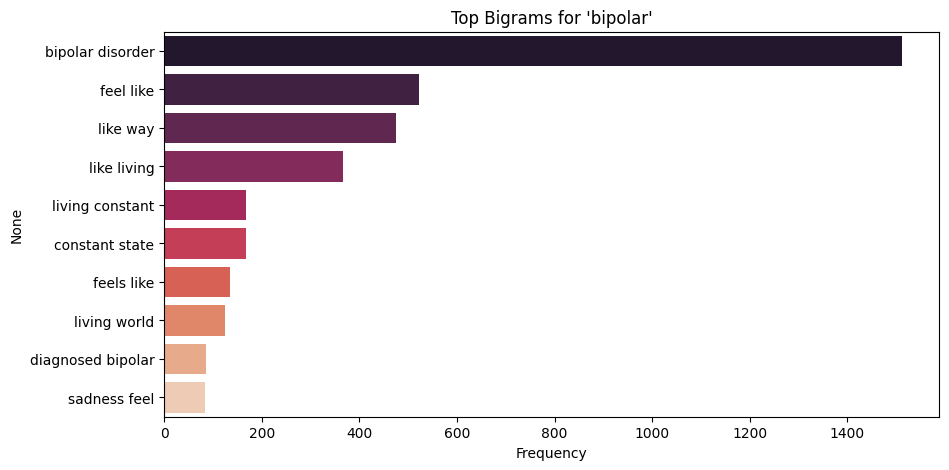

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Focus on a specific label (e.g., 'bipolar')
label = 'bipolar'
texts = df[df['Labels'] == label]['Tweets'].astype(str)

# Get top 10 bigrams
vec = CountVectorizer(ngram_range=(2, 2), max_features=10, stop_words='english')
bigrams = vec.fit_transform(texts)
bigram_counts = pd.DataFrame(bigrams.sum(axis=0), columns=vec.get_feature_names_out()).T.sort_values(0, ascending=False)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=bigram_counts[0], y=bigram_counts.index, palette="rocket")
plt.title(f"Top Bigrams for '{label}'")
plt.xlabel("Frequency")
plt.show()

#### 2.0 Processing data

In [13]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|@\w+|#\w+', '', text)  # Remove URLs, mentions, hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['Tweets'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [14]:
label_map = {
    'major depressive': 'depression',
    'atypical': 'depression',
    'psychotic': 'mania',  # Verify if these are manic psychosis cases
    'no': 'euthymia',
    'bipolar': 'depression'  # Assuming these are depressive-phase tweets
}
df['bipolar_state'] = df['Labels'].map(label_map).fillna('unknown')

3.0 Feature Engineering

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['processed_text'])

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

# Analyze cluster keywords
for i in range(3):
    cluster_texts = df[clusters == i]['processed_text']
    print(f"Cluster {i} Keywords:", " ".join(cluster_texts.sample(3)))

Cluster 0 Keywords: actually participated sheep slaughter another country yes tough however culture also sheep tasted like chicken joking dayfiance day fiance way never accommodated always needing work school system pushed time untreated hypersomnia actually threatened mother legal action preventing yes im sure lot dont know cymbalta weened medication postpartum depression fun awareness whats going scientifically definitely helpful
Cluster 1 Keywords: used love mother feel like im going motion feel guilty feeling way cant help know grateful baby feel sadness cant stop cry matter hard try feel like im losing dont know find way back world around feel bleak gray like there light end tunnel like im living constant state numbness cant escape
Cluster 2 Keywords: tw know sometimes think people forget diagnosed major depressive disorder diagnosed even sister dad died didnt get therapy tried unalive guy im curious diagnosed diagnosed adhd generalized anxiety disorder major depressive disorder l

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Get top 10 terms per cluster
terms = tfidf.get_feature_names_out()
for i in range(3):  # Assuming 3 clusters
    cluster_center = kmeans.cluster_centers_[i]
    top_terms_idx = cluster_center.argsort()[-10:][::-1]
    print(f"Cluster {i} (Likely State): {[terms[idx] for idx in top_terms_idx]}")

Cluster 0 (Likely State): ['depression', 'hypersomnia', 'postpartum', 'psychotic', 'sleep', 'im', 'think', 'dont', 'atypical', 'like']
Cluster 1 (Likely State): ['like', 'im', 'feel', 'cant', 'feeling', 'there', 'hard', 'find', 'living', 'way']
Cluster 2 (Likely State): ['disorder', 'bipolar', 'depressive', 'major', 'anxiety', 'im', 'diagnosed', 'also', 'ive', 'mental']


In [18]:
df.head(5)

,Tweets,Labels,tweet_length,sentiment,processed_text,bipolar_state
0,I been going thru depression I didnt even rea...,postpartum,265,0.211111,going thru depression didnt even realize till ...,unknown
1,"@keshab_mahanta hello Health minister sir,I m ...",postpartum,244,-0.202778,hello health minister siri working mother irri...,unknown
2,FYI in case anyone is concerned - I am NOT act...,postpartum,266,-0.033333,fyi case anyone concerned actually getting dru...,unknown
3,@victorr_ugo Thankful I am able to hold my bab...,postpartum,98,0.500000,thankful able hold baby suffering depression 8...,unknown
4,I think I might be suffering from depression ...,postpartum,63,-0.100000,think might suffering depression minus baby,unknown


In [19]:
df['bipolar_state'].value_counts()

,count
bipolar_state,
depression,6940
unknown,3759
mania,2312
euthymia,1985


In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Use a robust publicly-available model
MODEL_NAME = "bert-base-uncased"  # or "roberta-base" or "distilbert-base-uncased"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=3  # euthymia (0), depression (1), mania (2)
)

inputs = tokenizer(
    df['processed_text'].tolist(),  # Use the preprocessed text column
    padding=True,
    truncation=True,
    return_tensors="pt"  # Return PyTorch tensors
)


# Your existing training code can remain the same...
valid_indices = df['bipolar_state'].isin(['euthymia', 'depression', 'mania']).values
inputs['input_ids'] = inputs['input_ids'][valid_indices]
inputs['attention_mask'] = inputs['attention_mask'][valid_indices]

labels = df['bipolar_state'][valid_indices].map({'euthymia': 0, 'depression': 1, 'mania': 2}).astype(int)
dataset = torch.utils.data.TensorDataset(inputs['input_ids'], inputs['attention_mask'], torch.tensor(labels.values))


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
from imblearn.over_sampling import RandomOverSampler

# Balance the dataset using RandomOverSampler
oversampler = RandomOverSampler(random_state=SEED)

# Ensure X_to_resample and y_to_resample have compatible shapes and are NumPy arrays
X_to_resample = inputs['input_ids'].numpy()
y_to_resample = labels # Convert labels to a NumPy array

# Trim X_to_resample and y_to_resample to the same length to avoid mismatch
min_len = min(X_to_resample.shape[0], y_to_resample.shape[0])
X_to_resample = X_to_resample[:min_len]
y_to_resample = y_to_resample[:min_len]

X_resampled, y_resampled = oversampler.fit_resample(X_to_resample, y_to_resample)

# Convert the resampled data back to tensors
inputs_resampled = {
    'input_ids': torch.tensor(X_resampled),
    'attention_mask': torch.tensor([inputs['attention_mask'][i].numpy()
                                     for i in oversampler.sample_indices_])
}
labels_resampled = torch.tensor(y_resampled)

# Create a new dataset using the resampled data
dataset_resampled = torch.utils.data.TensorDataset(inputs_resampled['input_ids'], inputs_resampled['attention_mask'], labels_resampled)

# Split the resampled data into training and validation sets
train_size = int(0.8 * len(dataset_resampled))
val_size = len(dataset_resampled) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset_resampled, [train_size, val_size])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [22]:
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 3 # Number of training epochs. Adjust as needed.
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()


    # Evaluation
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in val_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())


    print(classification_report(true_labels, predictions))
    print(f"F1 Score (Macro): {f1_score(true_labels, predictions, average='macro')}")


              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1359
           1       0.96      0.94      0.95      1401
           2       0.95      0.97      0.96      1404

    accuracy                           0.97      4164
   macro avg       0.97      0.97      0.97      4164
weighted avg       0.97      0.97      0.97      4164

F1 Score (Macro): 0.9656972459408891
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1359
           1       0.99      0.93      0.96      1401
           2       0.94      0.99      0.97      1404

    accuracy                           0.97      4164
   macro avg       0.97      0.97      0.97      4164
weighted avg       0.97      0.97      0.97      4164

F1 Score (Macro): 0.973037483696641
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1359
           1       0.99      0.96      0.97      1401
  

In [24]:
import json

def dataloader_to_list(dataloader, label_map=None):
    all_data = []

    for batch in dataloader:
        # Access elements using numerical indices
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]

        for input_id, label in zip(input_ids, labels):  # Iterate over elements
            # If labels are integers, convert using label_map
            label_str = label_map[label.item()] if label_map else str(label.item())  # Get label as string

            item = {
                "text": tokenizer.decode(input_id, skip_special_tokens=True),  # Decode input_id to text
                "label": label_str,
                "audio_feat": [0.0] * 74,
                "video_feat": [0.0] * 35
            }
            all_data.append(item)

    return all_data

# Example: label map for 3-class depression (adjust as needed)
label_map = {
    0: "euthymia",
    1: "depression",
    2: "mania"
}

# Convert train and val
train_data = dataloader_to_list(train_dataloader, label_map)
val_data = dataloader_to_list(val_dataloader, label_map)

# Combine them
combined_data = train_data + val_data

# Save to JSON in Google Drive
import os

output_dir = "/content/drive/MyDrive/Research on BD NYU /development/multi class depression dataset"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "processed_multiclass_depression.json")

with open(output_path, "w") as f:
    json.dump(combined_data, f, indent=2)

print("Saved multiclass depression data to:", output_path)

Saved multiclass depression data to: /content/drive/MyDrive/Research on BD NYU /development/multi class depression dataset/processed_multiclass_depression.json
